# An example of GPEI BO Process

In [30]:
%cd '/home/local/USHERBROOKE/aara2601/projects/quack-tsf/'

/home/local/USHERBROOKE/aara2601/projects/quack-tsf


In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import numpy as np

from scipy.stats import norm
# Corrected expected improvement function using scipy.stats.norm for the normal distribution functions
def expected_improvement(x, pred_mean, pred_std, best_observation):
    z = (pred_mean - best_observation) / pred_std
    ei = (pred_mean - best_observation) * norm.cdf(z) + pred_std * norm.pdf(z)
    return ei

# Objective function (we can keep using a simple sinusoidal function as an example)
def true_objective_function(x):
    return np.sin(x) + 0.5 * np.cos(x * 2)

# Define initial observations (randomly chosen for demonstration)
x_observations = np.linspace(0.1, 10, 8).reshape(-1, 1)
print(x_observations.shape)

y_observations = true_objective_function(x_observations).ravel()

# Define a new Gaussian process with RBF kernel
kernel_rbf = RBF(length_scale=1.0)
gp_rbf = GaussianProcessRegressor(kernel=kernel_rbf, n_restarts_optimizer=9)

# Fit to observed data
gp_rbf.fit(x_observations, y_observations)

# Make the prediction on the meshed x-axis (ask for MSE as well)
x_pred = np.atleast_2d(np.linspace(-2, 12, 1000)).T
y_pred, sigma = gp_rbf.predict(x_pred, return_std=True)

# Update the best observation
best_observation = np.max(y_observations)

# Expected improvement calculation over the prediction
ei_values = expected_improvement(x_pred, y_pred, sigma, best_observation)

(8, 1)


'/home/local/USHERBROOKE/aara2601/projects/quack-tsf/storage/figures/gpei_bo.pdf'

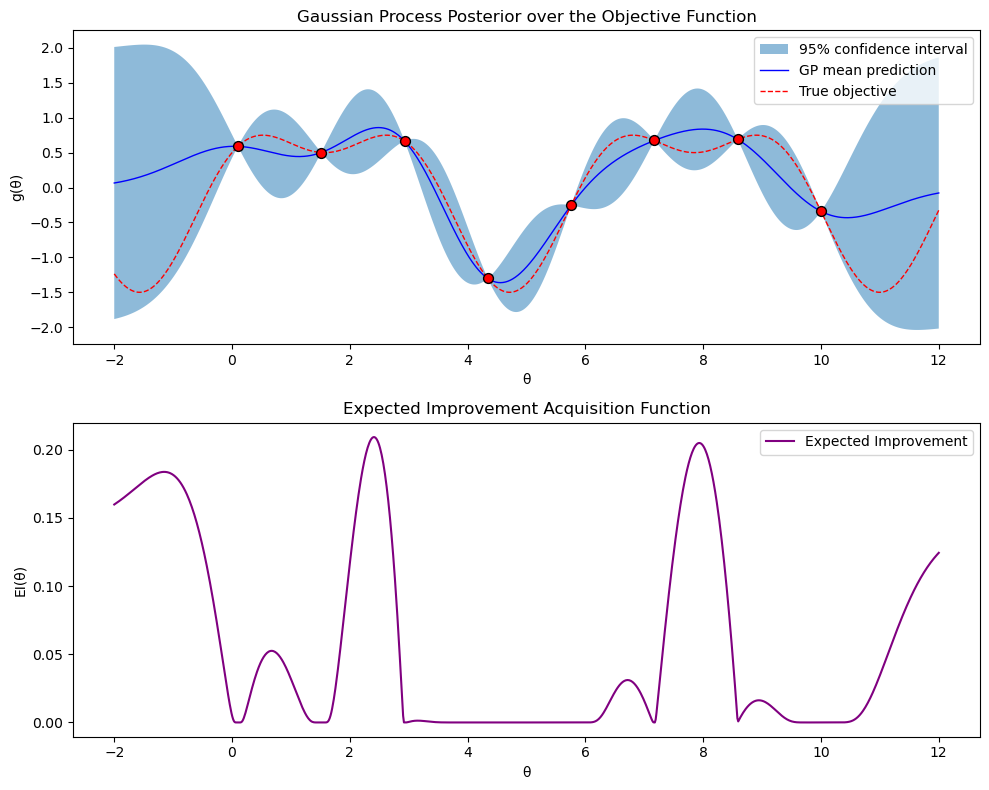

In [46]:
import matplotlib.pyplot as plt
import os
from src.utils.settings import PROJECT_ROOT_PATH


# Plotting the GP posterior and the EI acquisition function
plt.figure(figsize=(10, 8))

# Plot GP posterior
plt.subplot(2, 1, 1)
plt.fill_between(x_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5, label='95% confidence interval')
plt.plot(x_pred, y_pred, 'b-', lw=1, label='GP mean prediction')
plt.plot(x_pred, true_objective_function(x_pred), 'r--', lw=1, label='True objective')
plt.scatter(x_observations, y_observations, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title('Gaussian Process Posterior over the Objective Function')
plt.xlabel('θ')
plt.ylabel('g(θ)')
plt.legend()

# Plot EI acquisition function
plt.subplot(2, 1, 2)
plt.plot(x_pred, ei_values, 'purple', label='Expected Improvement')
plt.title('Expected Improvement Acquisition Function')
plt.xlabel('θ')
plt.ylabel('EI(θ)')
plt.legend()

# Tight layout to avoid overlap
plt.tight_layout()

# Save the figures
fig_parent_path = os.path.join(PROJECT_ROOT_PATH, 'storage/figures')
fig_filename = os.path.join(fig_parent_path, 'gpei_bo.pdf')

if not os.path.exists(fig_parent_path):
     os.mkdir(fig_parent_path)

plt.savefig(fig_filename, format='pdf')

pdf_filename